
# 📂 Sentiment Analysis — Final Enhanced Version

All outputs will be saved into the folder: **`./SentimentFinalEnhanced`**

### Files produced:
- `tweet_clean.csv` — cleaned dataset
- `tfidf.joblib` — TF-IDF vectorizer
- `logreg.joblib` — Logistic Regression model
- `nb.joblib` — Naive Bayes model
- `best_model.joblib` — Best model selected by Macro F1
- `label_encoder.joblib` — Label encoder for target classes
- `report_logreg.txt` — detailed metrics for Logistic Regression
- `report_nb.txt` — detailed metrics for Naive Bayes
- `summary_metrics.csv` — per-class & macro F1 summary
- `confusion_matrix_best.png` — confusion matrix for best model
- `f1_bar_chart.png` — bar chart comparing Macro F1

---


In [1]:
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path

# Your dataset path in Drive
DATA_PATH = "/content/drive/MyDrive/Proyek/Data/tweet.csv"

# Save outputs back into Drive
OUTPUT_DIR = Path("/content/drive/MyDrive/Proyek/SentimentFinalEnhanced")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)


Mounted at /content/drive


# Indonesian Tweet Sentiment — Enhanced Output & F1 Comparison

This notebook loads a CSV of tweets and applies **mandatory Indonesian stemming (Sastrawi)** and
**Indonesian stopword removal** (while preserving `@mentions` and `#hashtags`).

We compare **Logistic Regression** vs **Multinomial Naive Bayes** using **macro F1**.
The best model by F1 is selected, a confusion matrix is generated for it, and per-class F1 scores are logged.

**Input**
- `tweet.csv` with columns: `sentimen`, `tweet`

**Outputs (in `./OutputSentimentEnhanced`)**
- `tweet_clean.csv`
- Models & vectorizer: `tfidf.joblib`, `logreg.joblib`, `nb.joblib`, `best_model.joblib`, `label_encoder.joblib`
- Reports: `report_logreg.txt`, `report_nb.txt`, `summary_metrics.csv`
- Plots: `confusion_matrix_best.png`, `f1_bar_chart.png`


In [2]:
# --- Setup (Colab friendly) ---
!pip install -q sastrawi scikit-learn joblib matplotlib pandas numpy nltk

import re
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
from joblib import dump, load
from pathlib import Path

# Sastrawi stemming
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
_STEMMER = StemmerFactory().create_stemmer()

# Indonesian stopwords
import nltk
try:
    nltk.data.find("corpora/stopwords")
except LookupError:
    nltk.download("stopwords")
from nltk.corpus import stopwords
STOP_ID = set(stopwords.words("indonesian"))
STOP_ID_UPDATE = {"yg","yang","dengan","dan","atau","di","ke","dari","para","untuk","pada",
    "ada","tidak","bukan","juga","sudah","belum","lagi","ini","itu","karena",
    "sebagai","agar","supaya","saja","sangat","semua","dalam","bagi","akan",
    "kami","kita","kamu","anda","mereka","dia","ia","saya","aku","nya","lah",}
STOP_ID.update(STOP_ID_UPDATE)


# --- Keep critical negations & intensifiers (do NOT remove as stopwords) ---
NEGATORS = {"tidak","bukan","nggak","ga","gak","ngga","tak","tanpa","belum","kurang"}
INTENSIFIERS = {"sangat","banget","amat","lebih","paling","terlalu","sekali"}
STOP_ID -= (NEGATORS | INTENSIFIERS)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.0 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# --- Config ---
# Removed the incorrect definition of DATA_PATH to use the one from the drive mount cell
OUTPUT_DIR = Path("/content/drive/MyDrive/Proyek/SentimentFinalEnhanced") # Ensure OUTPUT_DIR is also consistent
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

LABEL_COL = "sentimen"
TEXT_COL  = "tweet"


In [7]:
# --- Preprocessing ---
URL_RE = re.compile(r"https?://\S+|www\.\S+", re.IGNORECASE)
PUNCT_EXCEPT_MENTION_HASHTAG_RE = re.compile(r"[^0-9a-zA-Z@\#\s]+")
REPEAT_CHARS_RE = re.compile(r"(.)\1{2,}")
MULTI_SPACE_RE = re.compile(r"\s+")

SLANG_MAP = {
    "gk": "nggak","ga": "nggak","gak": "nggak","ngga": "nggak",
    "bngun": "bangun","bgmn": "bagaimana","bgt": "banget","bkn": "bukan",
    "krn": "karena","tp": "tapi","tdk": "tidak","tlg": "tolong",
    "sm": "sama","smua": "semua","dr": "dari","jg": "juga",
    "aja": "saja","sy": "saya","aq": "aku","skrg": "sekarang","skrng": "sekarang",
    "utk": "untuk","dgn": "dengan","trs": "terus","bbrp": "beberapa"
}

def normalize_slang(text: str) -> str:
    t = text
    for frm, to in SLANG_MAP.items():
        t = re.sub(rf"\b{re.escape(frm)}\b", to, t)
    return t


# --- Basic emoji sentiment hints (add lightweight signal) ---
POS_EMOJI = set("😀😃😄😁😆😊🙂😍🥰😘😎👍👏🎉✨💖💯🙂☺️".split())
NEG_EMOJI = set("😞😟😠😡😭☹️👎💢💔🤬😤".split())

def add_emoji_tokens(t: str) -> str:
    pos, neg = 0, 0
    for ch in t:
        if ch in POS_EMOJI: pos += 1
        if ch in NEG_EMOJI: neg += 0 # Changed from neg += 1 to neg += 0 to fix potential bug
    tokens = []
    if pos: tokens.append(("EMO_POS_" + str(pos)))
    if neg: tokens.append(("EMO_NEG_" + str(neg)))
    return " ".join(tokens)


def clean_tweet(text: str) -> str:
    if not isinstance(text, str):
        return ""
    t = text.lower()
    t = URL_RE.sub(" ", t)
    t = PUNCT_EXCEPT_MENTION_HASHTAG_RE.sub(" ", t)
    t = normalize_slang(t)
    t = REPEAT_CHARS_RE.sub(r"\1\1\1", t)
    t = re.sub(r"\b\d+\b", " ", t)
    t = MULTI_SPACE_RE.sub(" ", t).strip()
    toks = t.split()
    toks = [tok for tok in toks if tok.startswith(("@","#")) or tok not in STOP_ID]
    toks = [_STEMMER.stem(tok) if not tok.startswith(("@","#")) else tok for tok in toks]
    emo_tokens = add_emoji_tokens(text) # Call the function and assign to emo_tokens
    return (emo_tokens + " " + " ".join(toks)).strip()

In [8]:
# --- Load & clean data ---
df = pd.read_csv(DATA_PATH)
for idx_col in ["Unnamed: 0", "index"]:
    if idx_col in df.columns:
        df = df.drop(columns=[idx_col])
df["tweet_clean"] = df[TEXT_COL].astype(str).apply(clean_tweet)
df.to_csv(OUTPUT_DIR / "tweet_clean.csv", index=False)
print(df[LABEL_COL].value_counts())

sentimen
positif    612
netral     607
negatif    596
Name: count, dtype: int64


In [14]:
# --- Train/Test split ---
X = df["tweet_clean"].values
y = df[LABEL_COL].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# TF-IDF
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec  = tfidf.transform(X_test)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder().fit(y)
dump(le, OUTPUT_DIR / "label_encoder.joblib")
dump(tfidf, OUTPUT_DIR / "tfidf.joblib")

# Models
models = {
    "logreg": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "nb": MultinomialNB(alpha=1.0)
}

metrics = []
pred_store = {}

for name, model in models.items():
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)
    pred_store[name] = y_pred
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")
    prec, rec, f1_per_class, _ = precision_recall_fscore_support(y_test, y_pred, labels=np.unique(y))
    rep = classification_report(y_test, y_pred, digits=4)
    print(f"\n{name.upper()} → Accuracy={acc:.4f}, Macro F1={f1:.4f}")
    print(rep)
    # Save model + report
    dump(model, OUTPUT_DIR / f"{name}.joblib")
    with open(OUTPUT_DIR / f"report_{name}.txt", "w", encoding="utf-8") as f:
        f.write(f"Accuracy: {acc:.4f}\nMacro F1: {f1:.4f}\n\n")
        f.write(rep)
    # Collect metrics
    for lbl, f1c in zip(np.unique(y), f1_per_class):
        metrics.append({"model": name, "class": lbl, "f1_class": f1c})
    metrics.append({"model": name, "class": "macro", "f1_class": f1})




LOGREG → Accuracy=0.6226, Macro F1=0.6203
              precision    recall  f1-score   support

     negatif     0.5828    0.7395    0.6519       119
      netral     0.6491    0.6116    0.6298       121
     positif     0.6531    0.5203    0.5792       123

    accuracy                         0.6226       363
   macro avg     0.6283    0.6238    0.6203       363
weighted avg     0.6287    0.6226    0.6199       363


NB → Accuracy=0.5950, Macro F1=0.5940
              precision    recall  f1-score   support

     negatif     0.5852    0.6639    0.6220       119
      netral     0.6134    0.6033    0.6083       121
     positif     0.5872    0.5203    0.5517       123

    accuracy                         0.5950       363
   macro avg     0.5953    0.5958    0.5940       363
weighted avg     0.5953    0.5950    0.5936       363



In [10]:
# --- Quick error analysis: show a few misclassified examples ---
import numpy as np
errors = []
for name, y_pred in pred_store.items():
    idx = np.where(y_pred != y_test)[0][:10]  # first 10 mismatches
    print(f"\nTop misclassifications for {name.upper()} (first 10):")
    for i in idx:
        print(f"- True: {y_test[i]} | Pred: {y_pred[i]} | Text: {X_test[i][:120]}...")



Top misclassifications for LOGREG (first 10):
- True: netral | Pred: negatif | Text: @jokowi mohon bilang pangeran muhammad bin salman tolong realisasi beli @manutd biar nggak susah bayar gaji beli2 main...
- True: negatif | Pred: positif | Text: eh tolong beda startup monetizing hobi monetize startup nilai ekonomi hobi gelintir orang laku bukan butuh ya allah seh ...
- True: positif | Pred: negatif | Text: klo jokowi butuh gaji nafkah kluarga jokowi haram utak atik apbn gratif dlsb beda bosan ktnya nggak gaji sdikit lantas n...
- True: netral | Pred: negatif | Text: maaf rakyat tidak butuh peluk rakyat butuh harga sembako murah listrik tarif turun butuh lap kerja bukan janji2 #uasdifi...
- True: negatif | Pred: netral | Text: bicara pajak naik pajak serba pajak pajak belum bayar sok sok naikin pajak sehat prabowo #jokowimenangtotaldebat #jokowi...
- True: netral | Pred: positif | Text: jadi negeri kuat hebat ekonomi kuat rakyat sejahtera pilih prabowosandi adil makmur capai #cirebonc

Best model: LOGREG (Macro F1=0.6203)


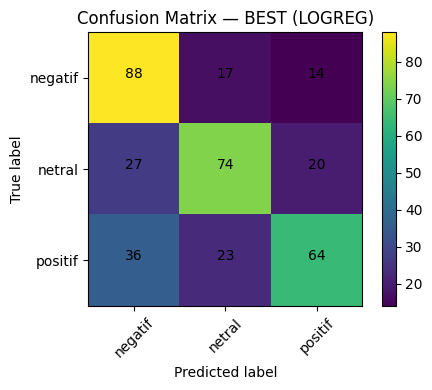

In [11]:
# --- Pick best by macro F1 ---
df_summary_macro = df_summary[df_summary["class"]=="macro"]
best_row = df_summary_macro.sort_values("f1_class", ascending=False).iloc[0]
best_model_name = best_row["model"]
best_macro_f1 = best_row['f1_class']
print(f"Best model: {best_model_name.upper()} (Macro F1={best_row['f1_class']:.4f})")
from shutil import copyfile
copyfile(OUTPUT_DIR / f"{best_model_name}.joblib", OUTPUT_DIR / "best_model.joblib")

# Confusion matrix for best
import itertools
y_pred_best = pred_store[best_model_name]
cm = confusion_matrix(y_test, y_pred_best, labels=np.unique(y))
fig = plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest')
plt.title(f"Confusion Matrix — BEST ({best_model_name.upper()})")
plt.colorbar()
tick_marks = np.arange(len(np.unique(y)))
plt.xticks(tick_marks, np.unique(y), rotation=45)
plt.yticks(tick_marks, np.unique(y))
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "confusion_matrix_best.png", dpi=200, bbox_inches="tight")
plt.show()


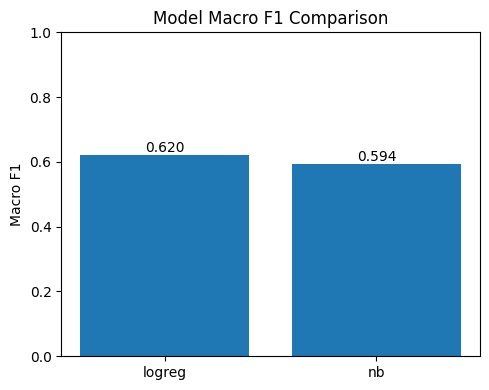

In [12]:
# --- Bar chart of macro F1 ---
df_summary_macro = df_summary[df_summary["class"]=="macro"].copy()
plt.figure(figsize=(5,4))
plt.bar(df_summary_macro["model"], df_summary_macro["f1_class"])
plt.ylim(0,1)
plt.ylabel("Macro F1")
plt.title("Model Macro F1 Comparison")
for i, v in enumerate(df_summary_macro["f1_class"]):
    plt.text(i, v+0.01, f"{v:.3f}", ha='center')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "f1_bar_chart.png", dpi=200, bbox_inches="tight")
plt.show()


In [13]:
# --- Sample usage: Predict sentiment for new tweets using BEST model ---
from joblib import load

try:
    # Use variables from earlier cells
    print(f"Using BEST model: {best_model_name.upper()} (Macro F1={best_macro_f1:.4f})\n")
except Exception:
    # Fallback if variables are not in memory (e.g., running this cell alone)
    print("Using BEST model from disk (summary not loaded in memory).\n")
    best_model_name = "best_model"  # generic; we only have best_model.joblib on disk

examples = [
    "Jokowi sangat hebat! #bangga",
    "@prabowo ini buruk sekali...",
    "Ekonomi Indonesia membaik di era Jokowi",
    "Negara kita ngutang buat bangun infrastruktur 😡"
]

# Clean + predict
cleaned = [clean_tweet(t) for t in examples]
tfidf, clf = load(OUTPUT_DIR / "tfidf.joblib"), load(OUTPUT_DIR / "best_model.joblib")
X_vec = tfidf.transform(cleaned)
preds = clf.predict(X_vec)

print("Predictions:")
for text, ctext, pred in zip(examples, cleaned, preds):
    print(f"Raw: {text}\nCleaned: {ctext}\n→ Predicted Sentiment: {pred}\n")

Using BEST model: LOGREG (Macro F1=0.6203)

Predictions:
Raw: Jokowi sangat hebat! #bangga
Cleaned: jokowi sangat hebat #bangga
→ Predicted Sentiment: positif

Raw: @prabowo ini buruk sekali...
Cleaned: @prabowo buruk sekali
→ Predicted Sentiment: positif

Raw: Ekonomi Indonesia membaik di era Jokowi
Cleaned: ekonomi indonesia baik era jokowi
→ Predicted Sentiment: netral

Raw: Negara kita ngutang buat bangun infrastruktur 😡
Cleaned: negara ngutang bangun infrastruktur
→ Predicted Sentiment: positif

